In [1]:
from sentinelhub import SHConfig
from dotenv import load_dotenv
import os
import numpy as np
import datetime
import os
import matplotlib.pyplot as plt
from config import IMAGE_SIZE
import cv2
from utils import generated_lsm_mask
from PIL import Image
from torch.utils.data import DataLoader
from dataset import Image_dataset
from generator_model import Generator
from torch import optim
import torch
from config import DEVICE
import config
from tqdm import tqdm

from skimage.metrics import structural_similarity as ssim
import cv2

# Load model
gen = Generator(in_channels=3, inter_images=4, out_channels=3)
checkpoint = torch.load("model/gen_LSM_v2.pth.tar", map_location=torch.device(DEVICE))
gen.load_state_dict(checkpoint['state_dict'])

optimizer = optim.Adam(gen.parameters())
optimizer.load_state_dict(checkpoint['optimizer'])


torch.Size([5, 128, 100, 100])


In [2]:
def generated_lsm_mask(gen, image_seq, inter_images_num=4):
    inter_image_dict = {}
    input_image = image_seq[:, :config.IMAGE_SIZE, :]
    for idx in range(inter_images_num):
        start_idx = config.IMAGE_SIZE * (idx + 1)
        end_idx = config.IMAGE_SIZE * (idx + 2)
        inter_image_dict[idx] = image_seq[:, start_idx:end_idx, :]

    target_image = image_seq[:, config.IMAGE_SIZE * (inter_images_num + 1):, :]

    for idx, inter_image in enumerate(inter_image_dict.values()):
        inter_image_dict[idx] = config.transform_only_input(image=inter_image)["image"]

    target_image = config.transform_only_mask_binarize(image=target_image)["image"]
    input_image = config.transform_only_input(image=input_image)["image"]

    generated_output = gen(input_image.unsqueeze(0), z1=inter_image_dict[0].unsqueeze(0), 
                              z2=inter_image_dict[1].unsqueeze(0), 
                              z3=inter_image_dict[2].unsqueeze(0), 
                              z4=inter_image_dict[3].unsqueeze(0))
    # return generated_output
    return (generated_output[0].permute(1,2,0).detach().numpy() > 0.5) * 1., (target_image.permute(1,2,0).detach().numpy() > 0.5) * 1.

In [3]:
def ssim_score(im1, im2):
    # Load two images in grayscale
    img1 = im1.astype('float32')
    img2 = im2.astype('float32')

    # assert img1.max() == img2.max() ## this might not work everytime

    # Resize to match if necessary
    img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]))

    # Compute SSIM between two images
    score, diff = ssim(img1, img2, channel_axis=-1, data_range=im1.max(), full=True)
    return score


In [ ]:
scores = []
for file in tqdm(os.listdir("Dataset")):
    if not file.endswith(".jpg"): continue
    image = np.array(Image.open(f"Dataset/{file}"))
    generated = generated_lsm_mask(gen=gen, image_seq=image, inter_images_num=4)
    score = ssim_score(generated[0], generated[1])
    if not np.isnan(score):
        scores.append(score)

  0%|          | 4/870 [00:03<11:04,  1.30it/s]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skimage/metrics/_structural_similarity.py:251: RuntimeWarning: invalid value encountered in divide
  S = (A1 * A2) / D
100%|██████████| 870/870 [13:03<00:00,  1.11it/s]


In [117]:
sum(scores) / len(scores)

0.899225611699222

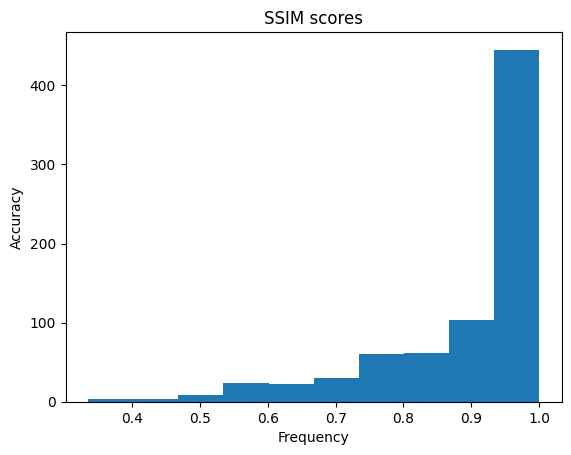

In [124]:
plt.hist(scores)
plt.title("SSIM scores")
plt.xlabel("Frequency")
plt.ylabel("Accuracy")
plt.show()


Testing induvidually

In [ ]:

score

0.563488

In [29]:
def ssim_and_predict(img_path: str):
    image = np.array(Image.open(img_path))
    generated = generated_lsm_mask(gen=gen, image_seq=image, inter_images_num=4)
    score = ssim_score(generated[0], generated[1])

    plt.figure(figsize=(10,10))

    plt.subplot(1,3,1)
    plt.title("Inputs")
    plt.imshow(image[:, :image.shape[0]*5, :])
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.title("Ground Truth")
    plt.imshow(generated[1])
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.title(f"Predicted | SSIM Score: {score:.4f}")
    plt.imshow(generated[0])
    plt.axis("off")

    plt.tight_layout()
    plt.show()

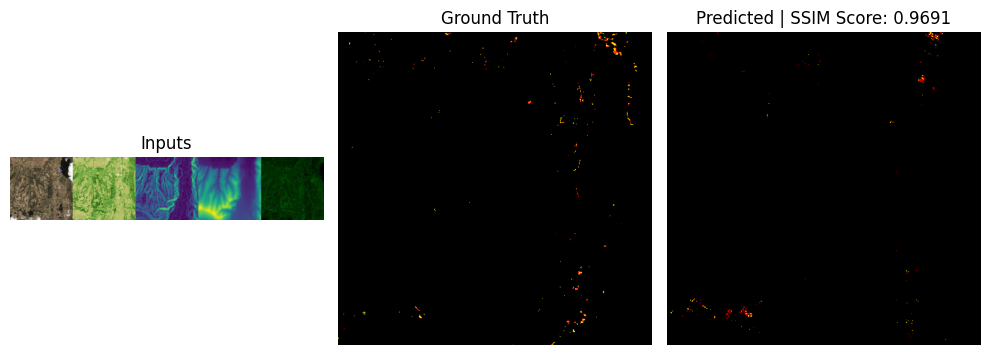

In [33]:
ssim_and_predict("Dataset/Highway No 174 Landslide in Yên Bái Province.jpg")

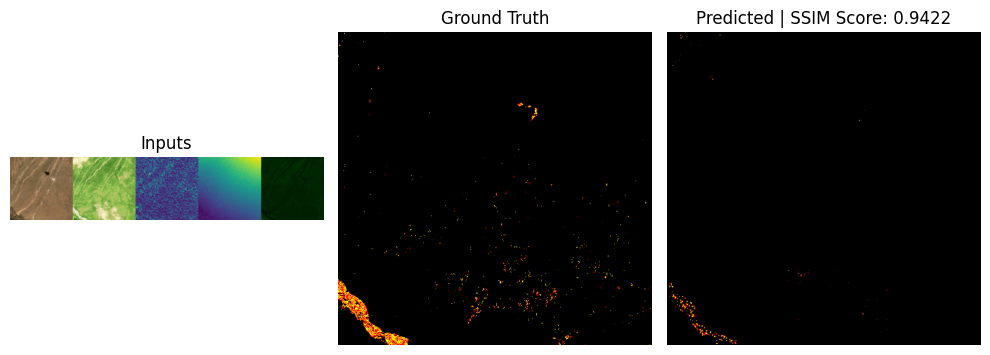

In [34]:
ssim_and_predict("Dataset/Hpakant Jade Mining Region Landlside.jpg")

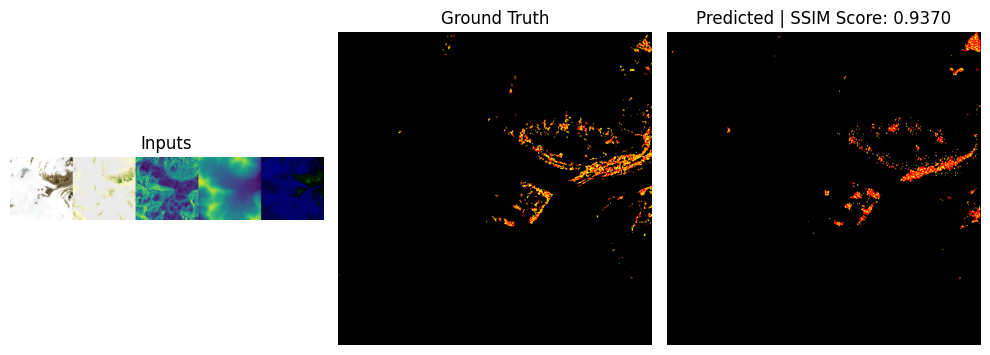

In [35]:
ssim_and_predict("Dataset/Kattipara Landslide.jpg")

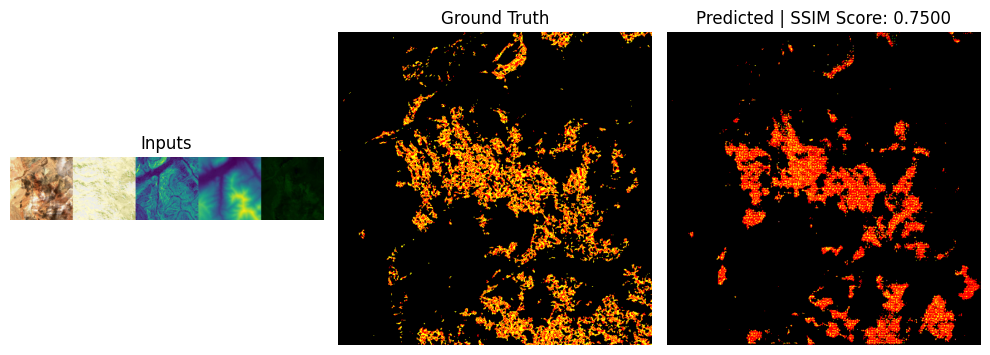

In [36]:
ssim_and_predict("Dataset/Kot Village Landslide in Tehri District.jpg")

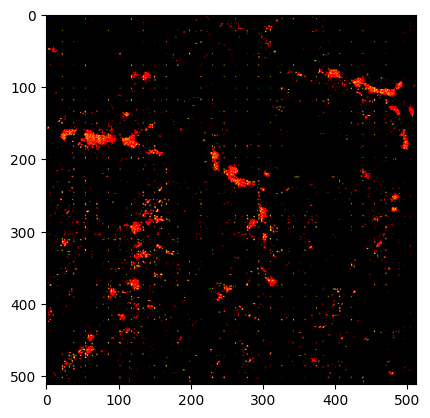

In [ ]:
Kot Village Landslide in Tehri District